In [1]:
# GOES on AWS python utility: https://github.com/palexandremello/goes-py
!pip install goespy

# GOES on AWS: https://docs.opendata.aws/noaa-goes16/cics-readme.html ; https://registry.opendata.aws/noaa-goes/

You are using pip version 9.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [11]:
import rasterio as rio
import rasterio.plot
import pyproj
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import cartopy.crs as ccrs
from goespy.Downloader import ABI_Downloader # https://github.com/palexandremello/goes-py


======================================== goes-py =========================================
 A Python package can be useful to download dataset from goes satellite on AWS  0.2.1v


In [42]:
def ABIangle2LatLon(x, y, H, req, rpol, lon_0):
    '''Find the latitude and longitude (degrees) of point P given x and y, ABI elevation and scanning angle (radians)'''
    
    # intermediate calculations
    a = np.sin(x)**2 + ( np.cos(x)**2 * ( np.cos(y)**2 + ( req**2 / rpol**2 ) * np.sin(y)**2 ) )
    b = -2 * H * np.cos(x) * np.cos(y)
    c = H**2 - req**2

    rs = ( -b - np.sqrt( b**2 - 4*a*c ) ) / ( 2 * a ) # distance from satellite point (S) to P
    
    Sx = rs * np.cos(x) * np.cos(y)
    Sy = -rs * np.sin(x)
    Sz = rs * np.cos(x) * np.sin(y)
    
    # calculate lat and lon
    lat = np.arctan( ( req**2 / rpol**2 ) * ( Sz / np.sqrt( ( H - Sx )**2 + Sy**2 ) ) )
    lat = np.degrees(lat)
    lon = lon_0 - np.arctan( Sy / ( H - Sx ))
    
    return (lat,lon)

In [12]:
bucket = 'noaa-goes16'
year='2019'
month='03'
day='01'
hour='12'
product='ABI-L1b-RadC'
channel='C14'

In [13]:
filepath = '/home/jovyan/goes16/{}/{}/{}/{}/{}/{}/'.format(year,month,day,product,hour,channel)
if not os.path.exists(filepath):
    ABI = ABI_Downloader(bucket,year,month,day,hour,product,channel)

In [14]:
file_list = os.listdir(filepath)
file_list

['OR_ABI-L1b-RadC-M3C14_G16_s20190601222133_e20190601224506_c20190601224555.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190601227133_e20190601229506_c20190601229552.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190601237133_e20190601239506_c20190601239554.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190601217133_e20190601219506_c20190601219555.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190601222133_e20190601224506_c20190601224555.tif',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190601212133_e20190601214506_c20190601214553.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190601202133_e20190601204506_c20190601204556.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190601247133_e20190601249506_c20190601249556.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190601252133_e20190601254506_c20190601254554.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190601207133_e20190601209506_c20190601209555.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190601232133_e20190601234506_c20190601234555.nc',
 'OR_ABI-L1b-RadC-M3C14_G16_s20190601222133_e20190601224506_c20190601224555.ncOR_ABI-L1b-RadC-M3C14_G16_s201

In [23]:
# pick a file from this list
file = filepath + file_list[0]

In [41]:
# open dataset using xarray
c14 = xr.open_dataset(filepath + file_list[0])

In [61]:
def getProj4string(goes_imager_projection):
    '''make a proj4 string from goes imager projection information'''
    proj_string = '"+proj=geos +ellps=GRS80 +h={h} +a={a} +rf={rf} +lon_0={lon0} +lat_0={lat0} +sweep={sweep}"'.format(
        h=c14.goes_imager_projection.perspective_point_height,
        a=c14.goes_imager_projection.semi_major_axis,
        rf=c14.goes_imager_projection.inverse_flattening,
        lon0=c14.goes_imager_projection.longitude_of_projection_origin,
        lat0=c14.goes_imager_projection.latitude_of_projection_origin,
        sweep=c14.goes_imager_projection.sweep_angle_axis)
    return proj_string

In [62]:
# make a proj4 string from this file's projection information
proj_string = getProj4string(c14.goes_imager_projection)

In [63]:
# trying to use gdal to transform this and output as geotiff
src_filepath = 'HDF5:"{file}"://{sds}'.format(file=file,sds='Rad')
dest_filepath = '{path}{fname}.tif'.format(path=filepath,fname=file_list[0][:-3])



#!gdal_translate -of GTiff $src_filepath $dest_filepath
!gdal_translate -of GTiff -a_srs $proj_string $src_filepath $dest_filepath
# -a_ullr -5424000 5424000 5424000 -5424000

Input file size is 2500, 1500
0...10...20...30...40...50...60...70...80...90...100 - done.


In [64]:
!gdalinfo $dest_filepath

Driver: GTiff/GeoTIFF
Files: /home/jovyan/goes16/2019/03/01/ABI-L1b-RadC/12/C14/OR_ABI-L1b-RadC-M3C14_G16_s20190601222133_e20190601224506_c20190601224555.tif
Size is 2500, 1500
Coordinate System is:
PROJCS["unnamed",
    GEOGCS["GRS 1980(IUGG, 1980)",
        DATUM["unknown",
            SPHEROID["GRS80",6378137,298.257222101]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433]],
    PROJECTION["Geostationary_Satellite"],
    PARAMETER["central_meridian",-75],
    PARAMETER["satellite_height",35786023],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    EXTENSION["PROJ4","+proj=geos +ellps=GRS80 +h=35786023.0 +a=6378137.0 +rf=298.2572221 +lon_0=-75.0 +lat_0=0.0 +sweep=x"]]
Metadata:
  AREA_OR_POINT=Area
  cdm_data_type=Image
  Conventions=CF-1.7
  dataset_name=OR_ABI-L1b-RadC-M3C14_G16_s20190601222133_e20190601224506_c20190601224555.nc
  date_created=2019-03-01T12:24:55.5Z
  id=a0c45800-2499-4635-a325-6d6949d3d0df
  institution=DOC/NOAA/NESD

In [55]:
# gdalwarp
tif_input = dest_filepath
tif_output = '{}_wgs84.tif'.format(dest_filepath[:-4])

!gdalwarp -t_srs EPSG:4326 $tif_input $tif_output
#'+proj=utm +zone=11 +datum=WGS84'

ERROR 1: The transformation is already "north up" or a transformation between pixel/line and georeferenced coordinates cannot be computed for /home/jovyan/goes16/2019/03/01/ABI-L1b-RadC/12/C14/OR_ABI-L1b-RadC-M3C14_G16_s20190601222133_e20190601224506_c20190601224555.tif. There is no affine transformation and no GCPs. Specify transformation option SRC_METHOD=NO_GEOTRANSFORM to bypass this check.


In [47]:
def bounds_latlon(ds):
    '''returns  ulx uly lrx lry lat lon coordinates from dataset'''
    req = ds.goes_imager_projection.semi_major_axis # semi major axis
    rpol = ds.goes_imager_projection.semi_minor_axis
    H = ds.goes_imager_projection.perspective_point_height + c14.goes_imager_projection.semi_major_axis
    lon_0 = ds.goes_imager_projection.longitude_of_projection_origin
    x = ds.x_image_bounds.values,
    y = ds.y_image_bounds.values
    result = ABIangle2LatLon(x,y,H,req,rpol,lon_0)
    return (result)

In [48]:
print(bounds_latlon(c14))

(array([[     nan, 14.62899]], dtype=float32), array([[      nan, -74.77137]], dtype=float32))


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


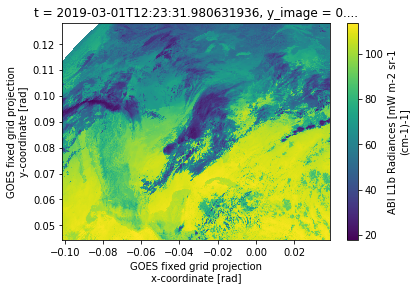

In [65]:
fig, ax = plt.subplots()
c14.Rad.plot(ax=ax)

In [67]:
# make a 2d array of both x and y in radians
x, y = np.meshgrid(c14.x.values, c14.y.values)

req = c14.goes_imager_projection.semi_major_axis # semi major axis
rpol = c14.goes_imager_projection.semi_minor_axis
H = c14.goes_imager_projection.perspective_point_height + c14.goes_imager_projection.semi_major_axis
lon_0 = c14.goes_imager_projection.longitude_of_projection_origin

lat, lon = ABIangle2LatLon(x,y,H,req,rpol,lon_0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


In [ ]:
lon2, lat2 = np.meshgrid(lon, lat)

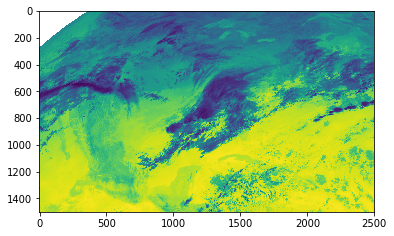

In [124]:
lon2

In [17]:
import glob

In [22]:
# https://stackoverflow.com/questions/53643062/lsa-saf-satellite-hdf5-plot-in-python-cartopy/53874872#53874872
#in_pathfiles = '/path/to/HDF5 files/*FAPAR*.h5' # Where .hdf5 files exist
out_pathfiles = ''#/home/jovyan/git/goes-view/test' # Where the new .tif file will be placed
#myfiles = glob.glob(in_pathfiles) #list of all files
myfiles = glob.glob(file)

for f in myfiles:
    print(f)
    src_filepath = f.split("\\")[-1]
    print("source filepath",src_filepath)

    f_out = src_filepath[:-3] + ".tif"  # splitting the .nc off the fileneame and making a new .tif filename
    print("destination filepath",f_out)

    f_rep = src_filepath[:-3] + "_rep.tif" # create a new final .tif filename for reprojection
    print("reprojected filepath",f_rep)

# Translating the satellite height and ellipitical values to xy values and filling the new _rep.tif file
# from the original .h5 file
os.system('gdal_translate -of GTiff -a_srs "+proj=geos +h=35785831 +a=6378169 +b=6356583.8 +no_defs"\
-a_ullr  -5568748.27576  5568748.27576 5568748.27576 -5568748.27576 "HDF5:{'+ src_filepath + '}://Rad '+ f_out)

# Mapping the new values and filling the new _rep.tif file
#os.system('gdalwarp -ot Float32 -s_srs "+proj=geos +h=35785831 +a=6378169 +b=6356583.8 +no_defs"\
#-t_srs EPSG:4326 -r near -of GTiff ' + f_out + ' ' + f_rep)

/home/jovyan/goes16/2019/03/01/ABI-L1b-RadC/12/C14/OR_ABI-L1b-RadC-M3C14_G16_s20190601222133_e20190601224506_c20190601224555.nc
source filepath /home/jovyan/goes16/2019/03/01/ABI-L1b-RadC/12/C14/OR_ABI-L1b-RadC-M3C14_G16_s20190601222133_e20190601224506_c20190601224555.nc
destination filepath /home/jovyan/goes16/2019/03/01/ABI-L1b-RadC/12/C14/OR_ABI-L1b-RadC-M3C14_G16_s20190601222133_e20190601224506_c20190601224555.tif
reprojected filepath /home/jovyan/goes16/2019/03/01/ABI-L1b-RadC/12/C14/OR_ABI-L1b-RadC-M3C14_G16_s20190601222133_e20190601224506_c20190601224555_rep.tif


In [5]:
# https://scitools.org.uk/cartopy/docs/v0.16/gallery/geostationary.html#sphx-glr-gallery-geostationary-py
try:
    from urllib2 import urlopen
except ImportError:
    from urllib.request import urlopen
from io import BytesIO

import cartopy.crs as ccrs
import matplotlib.pyplot as plt


def geos_image():
    """
    Return a specific SEVIRI image by retrieving it from a github gist URL.

    Returns
    -------
    img : numpy array
        The pixels of the image in a numpy array.
    img_proj : cartopy CRS
        The rectangular coordinate system of the image.
    img_extent : tuple of floats
        The extent of the image ``(x0, y0, x1, y1)`` referenced in
        the ``img_proj`` coordinate system.
    origin : str
        The origin of the image to be passed through to matplotlib's imshow.

    """
    url = ('https://gist.github.com/pelson/5871263/raw/'
           'EIDA50_201211061300_clip2.png')
    img_handle = BytesIO(urlopen(url).read())
    img = plt.imread(img_handle)
    img_proj = ccrs.Geostationary(satellite_height=35786000)
    img_extent = [-5500000, 5500000, -5500000, 5500000]
    return img, img_proj, img_extent, 'upper'



    


Retrieving image...
Projecting and plotting image (this may take a while)...


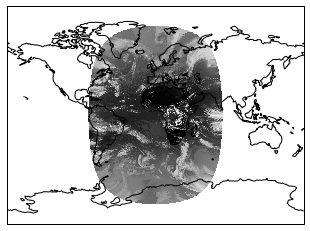

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Miller())
ax.coastlines()
ax.set_global()
print('Retrieving image...')
img, crs, extent, origin = geos_image()
print('Projecting and plotting image (this may take a while)...')
ax.imshow(img, transform=crs, extent=extent, origin=origin, cmap='gray')
plt.show()


In [ ]:
# brightness temp:
# T = [ fk2 / (alog((fk1 / ) + 1)) - bc1 ] / bc2